In [1]:
from cgdataset import World
import matplotlib.pyplot as plt
import numpy as np
from seeding_utils import point_in_regions, point_near_regions, vis_reg, compute_kernels, sorted_vertices
from independent_set_solver import solve_max_independent_set_integer
from scipy.sparse import lil_matrix
from tqdm import tqdm
from shapely.ops import cascaded_union
import shapely
from region_generation import generate_regions_ellipses_multi_threading
from doublegreedyhiddenset import DoubleGreedySeeding, HiddensetDoubleGreedy
from pydrake.geometry.optimization import (
    HPolyhedron, VPolytope, Iris, IrisOptions, Hyperellipsoid)
from functools import partial
from vislogging import Logger
from time import strftime, gmtime


/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
eps_sample = -0.05
eps = 0.05
alpha = 0.05
N=4000
seed = 1
use_region_obstacles_iris = 1
#use_region_visibility_obstacles = 0
region_pullback=0.25

world_name = "cheese102.instance.json"#small_polys[1] #"cheese205.instance.json"#fpg-poly_0000000060_h1.instance.json"#"srpg_iso_aligned_mc0000172.instance.json"##"fpg-poly_0000000070_h1.instance.json"
world = World("./data/evalexamples/"+world_name)
world.build_offset_cfree(eps_sample)

In [3]:
def sample_cfree_handle(n, m, regions=None):
	points = np.zeros((n,2))
	if regions is None: regions = []		
	for i in range(n):
		bt_tries = 0
		while bt_tries<m:
			point = world.sample_cfree_distance(1, eps = eps_sample)[0]
			#point = world.sample_cfree(1)[0]
			if point_near_regions(point, regions, tries = 100, eps = 0.1):
				bt_tries+=1
			else:
				break
		if bt_tries == m:
			return points, True
		
		points[i] = point
	return points, False


def mut_visreg(point, other, regions, world):
	return vis_reg(point.squeeze(), other.squeeze(), world, regions, n_checks=100)

los_handle = partial(mut_visreg, world = world)

def compute_coverage(regions):
    shapely_regions = []
    for r in regions:
        verts = sorted_vertices(VPolytope(r))
        shapely_regions.append(shapely.Polygon(verts.T))
    union_of_Polyhedra = cascaded_union(shapely_regions)
    return union_of_Polyhedra.area/world.cfree_polygon.area

def compute_coverage_cfree_tot(regions):
    shapely_regions = []
    for r in regions:
        verts = sorted_vertices(VPolytope(r))
        shapely_regions.append(shapely.Polygon(verts.T))
    union_of_Polyhedra = cascaded_union(shapely_regions)
    return union_of_Polyhedra.area/world.cfree_polygon.area

def iris_w_obstacles(points, ellipsoids, region_obstacles, old_regions = None, use_region_obstacles = use_region_obstacles_iris):
    if N>1:
        #+ region_obstacles
        obstacles = [r for r in world.obstacle_triangles]
        if use_region_obstacles:
            obstacles += region_obstacles
        regions, _, is_full = generate_regions_ellipses_multi_threading(points, ellipsoids, obstacles, world.iris_domain, compute_coverage, coverage_threshold=1-eps, old_regs = old_regions)
    else:
        #if N=1 coverage estimate happens at every step
        obstacles = [r for r in world.obstacle_triangles]
        if use_region_obstacles:
            obstacles += region_obstacles
        regions, _, _ = generate_regions_ellipses_multi_threading(points, ellipsoids, obstacles, world.iris_domain)
        is_full = 1-eps <= compute_coverage(old_regions+regions)
    return regions, is_full


In [4]:
from ellipse_utils import get_lj_ellipse

def get_kernel_iris_metrics(dg):
    hidden_set_idx = dg.hidden_set
    hidden_set = [dg.points[i] for i in hidden_set_idx]
    kernels = [dg.compute_kernel_of_hidden_point(i) for i in hidden_set_idx]
    for idx in range(len(kernels)):
        kernels[idx].append(dg.points[hidden_set_idx[idx]])
    kernelmats = [np.array(k).squeeze().reshape(-1,2) for k in kernels]
    seed_ellipses = [get_lj_ellipse(k) for k in kernelmats]
    seed_points = []
    for k,se in zip(kernels, seed_ellipses):
        center = se.center()
        if not los_handle(center, center, []):
            distances = np.linalg.norm(np.array(k).reshape(-1,2) - center, axis = 1).rehsape(-1)
            mindist_idx = np.argmin(distances)
            seed_points.append(k[mindist_idx])
        else:
            seed_points.append(center)

    #rescale seed_ellipses
    mean_eig_scaling = 1000
    seed_ellipses_scaled = []
    for e in seed_ellipses:
        eigs, _ = np.linalg.eig(e.A())
        mean_eig_size = np.mean(eigs)
        seed_ellipses_scaled.append(Hyperellipsoid(e.A()*(mean_eig_scaling/mean_eig_size), e.center()))
    return hidden_set, seed_ellipses_scaled, seed_ellipses, kernelmats

In [5]:
dg = HiddensetDoubleGreedy(
        alpha=0.0001,
        eps = 0.0001,
        max_samples = N,
        sample_node_handle=sample_cfree_handle,
        los_handle= los_handle,
        verbose=True
        ) 
dg.construct_independent_set([])
dg.refine_independent_set_greedy([])
hiddenset, seed_ellipses_scaled, seed_ellipses, kernels = get_kernel_iris_metrics(dg)
regions_step, is_full_iris = iris_w_obstacles(np.array(hiddenset).squeeze().reshape(len(hiddenset),-1), seed_ellipses_scaled, [], [])

[18:54:05] [DoubleGreedy] Point insertion attempts M: 92098
[18:54:05] [DoubleGreedy] 0.9999 probability that unseen region is less than 0.01 "%" of Cfree 
[18:54:05] [DoubleGreedy] New hidden point placed N =  0 it =  0
[18:54:05] [DoubleGreedy] New hidden point placed N =  1 it =  1
[18:54:05] [DoubleGreedy] New hidden point placed N =  2 it =  1
[18:54:05] [DoubleGreedy] New hidden point placed N =  3 it =  4
[18:54:05] [DoubleGreedy] New hidden point placed N =  4 it =  2
[18:54:05] [DoubleGreedy] New hidden point placed N =  5 it =  25
[18:54:05] [DoubleGreedy] New hidden point placed N =  6 it =  2
[18:54:05] [DoubleGreedy] New hidden point placed N =  7 it =  1
[18:54:05] [DoubleGreedy] New hidden point placed N =  8 it =  38
[18:54:05] [DoubleGreedy] New hidden point placed N =  9 it =  11
[18:54:06] [DoubleGreedy] New hidden point placed N =  10 it =  93
[18:54:07] [DoubleGreedy] New hidden point placed N =  11 it =  192
[18:54:07] [DoubleGreedy] New hidden point placed N =  1

100%|██████████| 21/21 [00:00<00:00, 163.37it/s]


[18:54:33] [DoubleGreedy] Kernel of size 33 found


100%|██████████| 34/34 [00:00<00:00, 95.02it/s] 


[18:54:34] [DoubleGreedy] Kernel of size 73 found


100%|██████████| 74/74 [00:01<00:00, 45.79it/s] 


[18:54:35] [DoubleGreedy] Kernel of size 148 found


100%|██████████| 149/149 [00:06<00:00, 22.21it/s]


[18:54:42] [DoubleGreedy] Kernel of size 42 found


100%|██████████| 43/43 [00:00<00:00, 78.56it/s] 


[18:54:43] [DoubleGreedy] Kernel of size 10 found


100%|██████████| 11/11 [00:00<00:00, 353.48it/s]


[18:54:43] [DoubleGreedy] Kernel of size 25 found


100%|██████████| 26/26 [00:00<00:00, 130.51it/s]


[18:54:43] [DoubleGreedy] Kernel of size 32 found


100%|██████████| 33/33 [00:00<00:00, 103.02it/s]


[18:54:44] [DoubleGreedy] Kernel of size 0 found
[18:54:44] [DoubleGreedy] Kernel of size 28 found


100%|██████████| 29/29 [00:00<00:00, 116.53it/s]


[18:54:44] [DoubleGreedy] Kernel of size 23 found


100%|██████████| 24/24 [00:00<00:00, 142.13it/s]


[18:54:44] [DoubleGreedy] Kernel of size 9 found


100%|██████████| 10/10 [00:00<00:00, 357.85it/s]


[18:54:44] [DoubleGreedy] Kernel of size 4 found


100%|██████████| 5/5 [00:00<00:00, 777.30it/s]


[18:54:44] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 633.20it/s]


[18:54:44] [DoubleGreedy] Kernel of size 3 found


100%|██████████| 4/4 [00:00<00:00, 985.39it/s]


[18:54:44] [DoubleGreedy] Kernel of size 0 found
[18:54:44] [DoubleGreedy] Kernel of size 2 found


100%|██████████| 3/3 [00:00<00:00, 1276.42it/s]


[18:54:44] [DoubleGreedy] Hidden point found to split into 3
[18:54:49] [DoubleGreedy] Kernel of size 20 found


100%|██████████| 21/21 [00:00<00:00, 160.31it/s]


[18:54:49] [DoubleGreedy] Kernel of size 35 found


100%|██████████| 36/36 [00:00<00:00, 91.61it/s] 


[18:54:50] [DoubleGreedy] Kernel of size 73 found


100%|██████████| 74/74 [00:01<00:00, 45.01it/s] 


[18:54:51] [DoubleGreedy] Kernel of size 40 found


100%|██████████| 41/41 [00:00<00:00, 80.54it/s] 


[18:54:52] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 690.70it/s]


[18:54:52] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 228.51it/s]


[18:54:52] [DoubleGreedy] Kernel of size 17 found


100%|██████████| 18/18 [00:00<00:00, 192.69it/s]


[18:54:52] [DoubleGreedy] Kernel of size 0 found
[18:54:52] [DoubleGreedy] Kernel of size 28 found


100%|██████████| 29/29 [00:00<00:00, 113.10it/s]


[18:54:52] [DoubleGreedy] Kernel of size 23 found


100%|██████████| 24/24 [00:00<00:00, 139.15it/s]


[18:54:52] [DoubleGreedy] Kernel of size 9 found


100%|██████████| 10/10 [00:00<00:00, 350.76it/s]


[18:54:52] [DoubleGreedy] Kernel of size 4 found


100%|██████████| 5/5 [00:00<00:00, 763.68it/s]


[18:54:52] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 622.89it/s]


[18:54:53] [DoubleGreedy] Kernel of size 3 found


100%|██████████| 4/4 [00:00<00:00, 973.33it/s]


[18:54:53] [DoubleGreedy] Kernel of size 0 found
[18:54:53] [DoubleGreedy] Kernel of size 2 found


100%|██████████| 3/3 [00:00<00:00, 1377.44it/s]


[18:54:53] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 624.46it/s]


[18:54:53] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 627.56it/s]


[18:54:53] [DoubleGreedy] Kernel of size 0 found
[18:54:53] [DoubleGreedy] Hidden point found to split into 2
[18:54:56] [DoubleGreedy] Kernel of size 20 found


100%|██████████| 21/21 [00:00<00:00, 160.39it/s]


[18:54:56] [DoubleGreedy] Kernel of size 35 found


100%|██████████| 36/36 [00:00<00:00, 91.84it/s] 


[18:54:57] [DoubleGreedy] Kernel of size 40 found


100%|██████████| 41/41 [00:00<00:00, 80.62it/s] 


[18:54:57] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 719.00it/s]


[18:54:57] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 191.44it/s]


[18:54:57] [DoubleGreedy] Kernel of size 17 found


100%|██████████| 18/18 [00:00<00:00, 192.55it/s]


[18:54:57] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 616.87it/s]


[18:54:57] [DoubleGreedy] Kernel of size 28 found


100%|██████████| 29/29 [00:00<00:00, 114.12it/s]


[18:54:58] [DoubleGreedy] Kernel of size 23 found


100%|██████████| 24/24 [00:00<00:00, 138.98it/s]


[18:54:58] [DoubleGreedy] Kernel of size 9 found


100%|██████████| 10/10 [00:00<00:00, 350.80it/s]


[18:54:58] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 616.19it/s]


[18:54:58] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 621.47it/s]


[18:54:58] [DoubleGreedy] Kernel of size 7 found


100%|██████████| 8/8 [00:00<00:00, 452.77it/s]


[18:54:58] [DoubleGreedy] Kernel of size 0 found
[18:54:58] [DoubleGreedy] Kernel of size 2 found


100%|██████████| 3/3 [00:00<00:00, 1350.39it/s]


[18:54:58] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 623.35it/s]


[18:54:58] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 624.32it/s]


[18:54:58] [DoubleGreedy] Kernel of size 0 found
[18:54:58] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 227.11it/s]


[18:54:58] [DoubleGreedy] Kernel of size 27 found


100%|██████████| 28/28 [00:00<00:00, 118.52it/s]


[18:54:58] [DoubleGreedy] Hidden point found to split into 2
[18:55:02] [DoubleGreedy] Kernel of size 20 found


100%|██████████| 21/21 [00:00<00:00, 160.10it/s]


[18:55:02] [DoubleGreedy] Kernel of size 33 found


100%|██████████| 34/34 [00:00<00:00, 97.51it/s] 


[18:55:02] [DoubleGreedy] Kernel of size 15 found


100%|██████████| 16/16 [00:00<00:00, 214.90it/s]


[18:55:02] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 227.74it/s]


[18:55:02] [DoubleGreedy] Kernel of size 17 found


100%|██████████| 18/18 [00:00<00:00, 192.56it/s]


[18:55:02] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 630.69it/s]


[18:55:02] [DoubleGreedy] Kernel of size 29 found


100%|██████████| 30/30 [00:00<00:00, 110.09it/s]


[18:55:03] [DoubleGreedy] Kernel of size 23 found


100%|██████████| 24/24 [00:00<00:00, 138.99it/s]


[18:55:03] [DoubleGreedy] Kernel of size 9 found


100%|██████████| 10/10 [00:00<00:00, 355.24it/s]


[18:55:03] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 620.80it/s]


[18:55:03] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 594.74it/s]


[18:55:03] [DoubleGreedy] Kernel of size 7 found


100%|██████████| 8/8 [00:00<00:00, 451.92it/s]


[18:55:03] [DoubleGreedy] Kernel of size 0 found
[18:55:03] [DoubleGreedy] Kernel of size 2 found


100%|██████████| 3/3 [00:00<00:00, 1528.91it/s]


[18:55:03] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 472.12it/s]


[18:55:03] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 465.28it/s]


[18:55:03] [DoubleGreedy] Kernel of size 0 found
[18:55:03] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 228.11it/s]


[18:55:03] [DoubleGreedy] Kernel of size 27 found


100%|██████████| 28/28 [00:00<00:00, 118.25it/s]


[18:55:03] [DoubleGreedy] Kernel of size 1 found


100%|██████████| 2/2 [00:00<00:00, 2717.40it/s]


[18:55:03] [DoubleGreedy] Kernel of size 1 found


100%|██████████| 2/2 [00:00<00:00, 2724.46it/s]


[18:55:03] [DoubleGreedy] Hidden point found to split into 2
[18:55:07] [DoubleGreedy] Kernel of size 20 found


100%|██████████| 21/21 [00:00<00:00, 160.73it/s]


[18:55:07] [DoubleGreedy] Kernel of size 8 found


100%|██████████| 9/9 [00:00<00:00, 395.60it/s]


[18:55:07] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 228.33it/s]


[18:55:07] [DoubleGreedy] Kernel of size 17 found


100%|██████████| 18/18 [00:00<00:00, 192.38it/s]


[18:55:07] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 619.83it/s]


[18:55:07] [DoubleGreedy] Kernel of size 29 found


100%|██████████| 30/30 [00:00<00:00, 110.49it/s]


[18:55:07] [DoubleGreedy] Kernel of size 23 found


100%|██████████| 24/24 [00:00<00:00, 139.66it/s]


[18:55:08] [DoubleGreedy] Kernel of size 9 found


100%|██████████| 10/10 [00:00<00:00, 350.49it/s]


[18:55:08] [DoubleGreedy] Kernel of size 4 found


100%|██████████| 5/5 [00:00<00:00, 752.21it/s]


[18:55:08] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 616.48it/s]


[18:55:08] [DoubleGreedy] Kernel of size 7 found


100%|██████████| 8/8 [00:00<00:00, 451.04it/s]


[18:55:08] [DoubleGreedy] Kernel of size 0 found
[18:55:08] [DoubleGreedy] Kernel of size 2 found


100%|██████████| 3/3 [00:00<00:00, 1365.63it/s]


[18:55:08] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 621.72it/s]


[18:55:08] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 613.73it/s]


[18:55:08] [DoubleGreedy] Kernel of size 0 found
[18:55:08] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 226.78it/s]


[18:55:08] [DoubleGreedy] Kernel of size 13 found


100%|██████████| 14/14 [00:00<00:00, 244.21it/s]


[18:55:08] [DoubleGreedy] Kernel of size 1 found


100%|██████████| 2/2 [00:00<00:00, 2255.61it/s]


[18:55:08] [DoubleGreedy] Kernel of size 1 found


100%|██████████| 2/2 [00:00<00:00, 2200.58it/s]


[18:55:08] [DoubleGreedy] Kernel of size 0 found
[18:55:08] [DoubleGreedy] Kernel of size 0 found
[18:55:08] [DoubleGreedy] Hidden point found to split into 2
[18:55:11] [DoubleGreedy] Kernel of size 20 found


100%|██████████| 21/21 [00:00<00:00, 163.44it/s]


[18:55:11] [DoubleGreedy] Kernel of size 9 found


100%|██████████| 10/10 [00:00<00:00, 358.82it/s]


[18:55:11] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 231.76it/s]


[18:55:11] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 634.09it/s]


[18:55:11] [DoubleGreedy] Kernel of size 29 found


100%|██████████| 30/30 [00:00<00:00, 112.04it/s]


[18:55:12] [DoubleGreedy] Kernel of size 23 found


100%|██████████| 24/24 [00:00<00:00, 141.38it/s]


[18:55:12] [DoubleGreedy] Kernel of size 9 found


100%|██████████| 10/10 [00:00<00:00, 351.36it/s]


[18:55:12] [DoubleGreedy] Kernel of size 4 found


100%|██████████| 5/5 [00:00<00:00, 763.29it/s]


[18:55:12] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 613.10it/s]


[18:55:12] [DoubleGreedy] Kernel of size 7 found


100%|██████████| 8/8 [00:00<00:00, 458.15it/s]


[18:55:12] [DoubleGreedy] Kernel of size 0 found
[18:55:12] [DoubleGreedy] Kernel of size 2 found


100%|██████████| 3/3 [00:00<00:00, 1364.89it/s]


[18:55:12] [DoubleGreedy] Kernel of size 5 found


100%|██████████| 6/6 [00:00<00:00, 611.09it/s]


[18:55:12] [DoubleGreedy] Kernel of size 4 found


100%|██████████| 5/5 [00:00<00:00, 769.88it/s]


[18:55:12] [DoubleGreedy] Kernel of size 0 found
[18:55:12] [DoubleGreedy] Kernel of size 14 found


100%|██████████| 15/15 [00:00<00:00, 230.10it/s]


[18:55:12] [DoubleGreedy] Kernel of size 13 found


100%|██████████| 14/14 [00:00<00:00, 249.14it/s]


[18:55:12] [DoubleGreedy] Kernel of size 1 found


100%|██████████| 2/2 [00:00<00:00, 2038.54it/s]


[18:55:12] [DoubleGreedy] Kernel of size 1 found


100%|██████████| 2/2 [00:00<00:00, 2111.94it/s]


[18:55:12] [DoubleGreedy] Kernel of size 0 found
[18:55:12] [DoubleGreedy] Kernel of size 0 found
[18:55:12] [DoubleGreedy] Kernel of size 4 found


100%|██████████| 5/5 [00:00<00:00, 765.44it/s]


[18:55:12] [DoubleGreedy] Kernel of size 1 found


100%|██████████| 2/2 [00:00<00:00, 2007.32it/s]


[18:55:12]  1 / 1
[18:55:14]  1 / 1


<ipython-input-3-2ab3c8399630>:30: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_of_Polyhedra = cascaded_union(shapely_regions)


[18:55:16]  1 / 1
[18:55:17]  1 / 1
[18:55:19]  1 / 1
[18:55:20]  1 / 1
[18:55:21]  1 / 1
[18:55:23]  1 / 1
[18:55:25]  1 / 1
[18:55:28]  1 / 1
[18:55:30]  1 / 1
[18:55:33]  1 / 1
[18:55:35]  1 / 1
[18:55:37]  1 / 1
[18:55:39]  1 / 1
[18:55:42]  1 / 1
[18:55:45]  1 / 1
[18:55:47]  1 / 1
[18:55:48]  1 / 1
[18:55:51]  1 / 1
[18:55:53]  1 / 1
[18:55:55]  1 / 1
[18:55:58]  1 / 1


In [6]:
from pydrake.all import Hyperellipsoid
from ellipse_utils import plot_ellipse



seed_ell_plot = seed_ellipses #[Hyperellipsoid(h.A()*0.1, h.center()) for h in seed_ellipses]

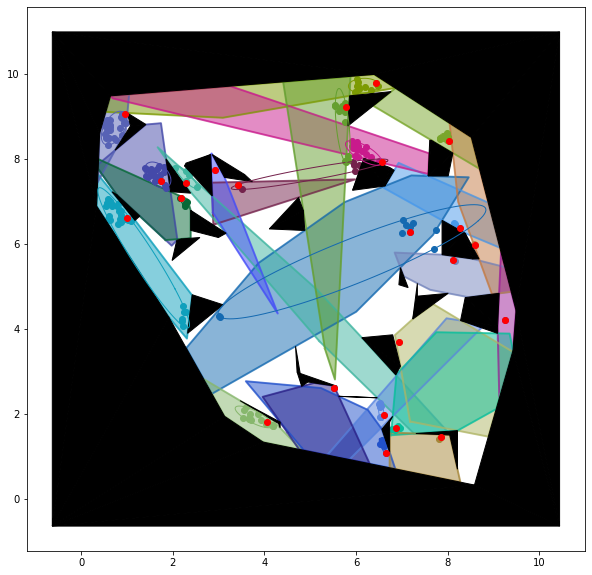

In [7]:
from utils import generate_random_colors

fig,ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))
world.plot_cfree(ax)

hs = np.array(hiddenset).squeeze()
plt.scatter(hs[:,0], hs[:,1], c = 'r', zorder=10)

colors = generate_random_colors(len(kernels))
for k,e, c, r in zip(kernels, seed_ell_plot, colors, regions_step):
    g = plt.scatter(k[:, 0], k[:, 1], color = c)
    plot_ellipse(ax, e, 100,color=c)
    world.plot_HPoly(ax, r, color = c)


In [8]:
len(regions_step)

23

In [9]:
compute_coverage(regions_step)

<ipython-input-3-2ab3c8399630>:30: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  union_of_Polyhedra = cascaded_union(shapely_regions)


0.790441214502968